In [39]:
import location as AL

from bs4 import BeautifulSoup as BS
import mechanicalsoup as MS

from datetime import datetime
from datetime import timedelta

from pytz import timezone

import ephem
import ephem.stars

import math
import matplotlib.pyplot as plt

import numpy as np
import requests
import time

In [40]:
lat_arg, lon_arg = AL.getLocation([])
print(lat_arg, lon_arg)

40.7471690 -73.9199318


In [41]:
"""
<option value="2056369">Battery</option>
<option value="2005428">Riverhead</option>
<option selected="selected" value="1941678">Sunnyside</option>
<option value="1961750">Treadwell</option>
"""

'\n<option value="2056369">Battery</option>\n<option value="2005428">Riverhead</option>\n<option selected="selected" value="1941678">Sunnyside</option>\n<option value="1961750">Treadwell</option>\n'

<h2>Get Passes from Heavens Above</h2>

In [42]:
def get_ha_passes():
    loginURL = 'https://heavens-above.com/login.aspx'
    satsURL = 'https://www.heavens-above.com/AllSats.aspx'
    br = MS.StatefulBrowser()
    login = br.open(loginURL)
    login.raise_for_status()
    login_form = MS.Form(login.soup.select_one('#aspnetForm'))
    login_form.input({'ctl00$cph1$Login1$UserName': 'akocica@aol.com', 'ctl00$cph1$Login1$Password': 'xxxxx'})
    resp = br.submit(login_form, login.url)
    br.open(satsURL)
    page = br.get_current_page()
    lf = MS.Form(page.select_one('#aspnetForm'))
    lf.set_select({'ctl00$ddlLocation':'1941678'})
    resp = br.submit(lf, satsURL)
    page = br.get_current_page()
    table = page.find("table", class_="standardTable")
    r = []
    for row in table.findAll("tr"):
        hr = []
        satid = ""
        for cell in row.findAll("td"):
            s = cell.text.strip()
            if len(cell.contents):
                c = str(cell.contents[0])
                q = c.find("satid=")
                if q != -1:
                    satid = c.split(';')[1].replace("satid=","").replace("&amp","")
            hr.append(s)
        hr.append(satid)
        if len(hr) > 1 and hr[1].replace('.','',1).replace('-','',1).isdigit() and float(hr[1]) < 3.0:
            r.append(hr)
    return r


TimeNow = time.perf_counter() 

ha = []
passes =  get_ha_passes()
for p in passes:
    ha.append([p[-1].rjust(8), p[0].ljust(24), p[1], p[2].ljust(4), p[4]])
ha.sort(key=lambda x: x[3])

distinct_sats = sorted(list(set([p[-1] for p in passes])))

print(round(time.perf_counter() - TimeNow,1),'seconds',len(distinct_sats),'Sats')

5.7 seconds 13 Sats


In [43]:
passes[0]

['ISS',
 '-1.0',
 '21:00:31',
 '10°',
 'NNW',
 '21:02:23',
 '14°',
 'N',
 '21:04:15',
 '10°',
 'NE',
 '25544']

<h3>Create a Dictionary of Satellite Data</h3>

In [34]:
pd = {}
for p in passes:
    pd[int(p[-1])] = p[0]
[ [_, pd[_]] for _ in [ _[0][0] for _ in observations]]

[[20580, 'Hubble Space Telescope'],
 [20625, 'Cosmos 2082 Rocket'],
 [23088, 'Cosmos 2278 Rocket'],
 [23343, 'Resurs 01 Rocket'],
 [25544, 'ISS'],
 [25994, 'Terra'],
 [28646, 'Lacrosse 5'],
 [44064, 'CREW DRAGON DEMO-1 DEB'],
 [44965, 'STARLINK-1087']]

<h2>Get TLE's from Heavens Above</h2>

In [6]:
TimeNow = time.perf_counter() 
parse_dict = {}
for sat in distinct_sats:
    url = "https://www.heavens-above.com/orbit.aspx?satid="+sat
    page = requests.get(url)
    soup = BS(page.text, 'html.parser')
    s = soup.find(id="ctl00_cph1_lblLine1").text
    if s:
        ss = soup.find(id="ctl00_cph1_lblLine2").text
        if ss:
            s = s  + '\n' + ss
    parse_dict[sat] = s
    
tle_dict = {}
for k, v in parse_dict.items():
    v = v.split('\n')
    tle_dict[k] = [k,v[0],v[1]]
sats = []
for tle in list(tle_dict.values()):
    sat = ephem.readtle(tle[0], tle[1], tle[2])
    norad = int(tle[1][2:7])
    name = tle[0].strip()
    label = (name+' '+str(norad)).ljust(16)
    sats.append([norad, name, label, sat])
    
print(round(time.perf_counter() - TimeNow,1),'seconds',len(list(parse_dict.keys())),'TLEs')

13.4 seconds 13 TLEs


<h2>Calculate Arcs for All Passes</h2>

In [44]:
TimeNow = time.perf_counter() 

dt = ephem.Date(datetime.utcnow())
dtl = ephem.localtime(dt)
print('Local : '+datetime.utcnow().strftime("%m/%d %H:%M")+' | UTC : '+dtl.strftime("%m/%d %H:%M"))

obs = ephem.Observer()
obs.date = dt
obs.lon = lon_arg
obs.lat = lat_arg
obs.elevation = 0

sun = ephem.Sun(obs)
sun.compute(obs)
te = ephem.Date(obs.next_rising(sun))

print("From ",ephem.localtime(obs.date).strftime("%m/%d %H:%M"),"to", ephem.localtime(te).strftime("%m/%d %H:%M"))
calculations = 0
observations = []
labels = []
for sat in sats:
    t = ephem.Date(datetime.utcnow())
    se = sat[3]
    wasVisible = False
    arc = []
    while t < te :
        obs.date = t        
        sun.compute(obs)
        sun_alt = math.degrees(sun.alt)
        se.compute(obs)
        sat_alt = math.degrees(se.alt)
        sat_az = math.degrees(se.az)
        if sat_alt > 10 and se.eclipsed is False and -18 < sun_alt < -6:
            wasVisible = True
            arc.append([sat[0], ephem.localtime(t), sat_az, sat_alt])
        else:
            if wasVisible:
                #print(sat[2])
                labels.append(sat[2])
                observations.append(arc)
                arc = []
                wasVisible = False
        calculations = calculations + 1
        t = ephem.Date(t + 5.0 * ephem.second)

print(round(time.perf_counter() - TimeNow,1),'seconds', calculations, 'calculations', len(observations), 'passes')

Local : 05/27 15:35 | UTC : 05/27 11:35
From  05/27 11:35 to 05/28 05:28
6.7 seconds 167303 calculations 10 passes


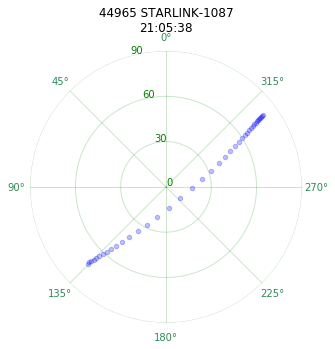

In [38]:
labels = {}
i = 0
for b in observations:
    id = b[0][0]
    tm = b[0][1]
    labels[id] = str(id) + " " + pd[id]+ "\n" + tm.strftime("%X")
    i = i + 1

j = 8
b = observations[j]
id = b[0][0]
tm = b[0][1] 
r = [90-_[3] for _ in b]

theta = np.radians([_[2] for _ in b])

s = 20
c = 'blue'

fig = plt.figure()
axp = fig.add_subplot(111, polar=True)
fig.set_size_inches(5,5)

#axp.set_theta_direction(-1)
axp.set_theta_zero_location("N")
axp.scatter(theta, r, s, color = c, alpha=0.25)
axp.set_rmax(90)
axp.set_rlabel_position(15)
axp.set_rticks(np.arange(0, 91, 30))
axp.grid(color='g', linestyle='-', linewidth=1, alpha=0.2)
axp.spines['polar'].set_visible(False)
axp.set_title(labels[id])
plt.setp(axp.get_xticklabels(), color='seagreen')
plt.setp(axp.get_yticklabels(), color='green')
#plt.tight_layout()
plt.show()

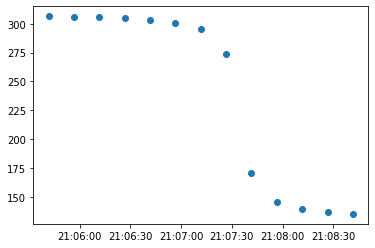

In [36]:
plt.plot_date([_[1] for _ in b], [_[2] for _ in b])

In [46]:
import location as AL

from bs4 import BeautifulSoup as BS
import mechanicalsoup as MS

from datetime import datetime
from datetime import timedelta
from pytz import timezone
import math
import ephem
import ephem.stars

import numpy as np
import requests
import time

import pickle

#----------------------------------------------------------------------




"""
	<option value="2056369">Battery</option>
	<option value="2005428">Riverhead</option>
	<option selected="selected" value="1941678">Sunnyside</option>
	<option value="1961750">Treadwell</option>

"""
#----------------------------------------------------------------------


def get_ha_passes():

    loginURL = 'https://heavens-above.com/login.aspx'
    satsURL = 'https://www.heavens-above.com/AllSats.aspx'

    br = MS.StatefulBrowser()
    login = br.open(loginURL)
    login.raise_for_status()

    login_form = MS.Form(login.soup.select_one('#aspnetForm'))
    login_form.input({'ctl00$cph1$Login1$UserName': 'akocica@aol.com', 'ctl00$cph1$Login1$Password': 'xxxxxx'})
    resp = br.submit(login_form, login.url)
    br.open(satsURL)
    page = br.get_current_page()

    lf = MS.Form(page.select_one('#aspnetForm'))
    lf.set_select({'ctl00$ddlLocation':'1941678'})
    resp = br.submit(lf, satsURL)
    page = br.get_current_page()

    table = page.find("table", class_="standardTable")
    r = []
    for row in table.findAll("tr"):
        hr = []
        satid = ""
        for cell in row.findAll("td"):
            s = cell.text.strip()
            if len(cell.contents):
                c = str(cell.contents[0])
                q = c.find("satid=")
                if q != -1:
                    satid = c.split(';')[1].replace("satid=","").replace("&amp","")
            hr.append(s)
        hr.append(satid)
        if len(hr) > 1 and hr[1].replace('.','',1).replace('-','',1).isdigit() and float(hr[1]) <= 3.0:
            r.append(hr)
    return r

#----------------------------------------------------------------------

TimeNow = time.perf_counter() 

lat_arg, lon_arg = AL.getLocation([])
print(lat_arg, lon_arg)
print()

ha = []
passes =  get_ha_passes()
pickle.dump( passes, open( "passes.p", "wb" ) )


passes = pickle.load( open( "passes.p", "rb" ) )
passes.sort(key=lambda x: x[2])
for p in passes:
    print(p[0].ljust(24), p[1].rjust(5), p[2], p[3].rjust(4), p[4].ljust(4), p[5], p[6].rjust(4), p[7].ljust(4) , p[8], p[9].rjust(4), p[10].ljust(4))
print()

distinct_sats = sorted(list(set([p[-1] for p in passes])))
parse_dict = {}
for sat in distinct_sats:
    url = "https://www.heavens-above.com/orbit.aspx?satid="+sat
    print('\t',url)
    page = requests.get(url)
    soup = BS(page.text, 'html.parser')
    s = soup.find(id="ctl00_cph1_lblLine1").text
    if s:
        ss = soup.find(id="ctl00_cph1_lblLine2").text
        if ss:
            s = s  + '\n' + ss
    parse_dict[sat] = s
    time.sleep(1)
    
tle_dict = {}
for k, v in parse_dict.items():
    v = v.split('\n')
    tle_dict[k] = [k,v[0],v[1]]
sats = []
for tle in list(tle_dict.values()):
    sat = ephem.readtle(tle[0], tle[1], tle[2])
    norad = int(tle[1][2:7])
    name = tle[0].strip()
    label = (name+' '+str(norad)).ljust(16)
    sats.append([norad, name, label, sat])
print()
print(round(time.perf_counter() - TimeNow,1),'seconds',len(list(tle_dict.keys())),'TLEs')

pickle.dump( tle_dict, open( "tle.p", "wb" ) )
tle_dict = pickle.load( open( "tle.p", "rb" ) )

#--------------------------------

dt = ephem.Date(datetime.utcnow())
dtl = ephem.localtime(dt)
print()
print('Local : ' + datetime.utcnow().strftime("%m/%d %H:%M"))
print('UTC   : ' + dtl.strftime("%m/%d %H:%M"))

obs = ephem.Observer()
obs.date = dt
obs.lon = lon_arg
obs.lat = lat_arg
obs.elevation = 0

sun = ephem.Sun(obs)
sun.compute(obs)
te = ephem.Date(obs.next_rising(sun))

sats = []
for tle in list(tle_dict.values()):
    sat = ephem.readtle(tle[0], tle[1], tle[2])
    norad = int(tle[1][2:7])
    name = tle[0].strip()
    label = (name+' '+str(norad)).ljust(16)
    sats.append([norad, name, label, sat])

print("From  :", ephem.localtime(obs.date).strftime("%m/%d %H:%M"))
print("To    :", ephem.localtime(te).strftime("%m/%d %H:%M"))
print()
calculations = 0
observations = []
for sat in sats:
    t = ephem.Date(datetime.utcnow())
    se = sat[3]
    wasVisible = False
    arc = []
    while t < te :
        obs.date = t        
        sun.compute(obs)
        sun_alt = math.degrees(sun.alt)
        se.compute(obs)
        sat_alt = math.degrees(se.alt)
        sat_az = math.degrees(se.az)
        if sat_alt > 10 and se.eclipsed is False and -18 < sun_alt < -6:
            if not wasVisible:
                    print('\t', sat[0], ephem.localtime(t).strftime("%m/%d %H:%M"), int(sat_az))
            wasVisible = True
            arc.append([sat[0], ephem.localtime(t), sat_az, sat_alt])
        else:
            if wasVisible:
                observations.append(arc)
                arc = []
                wasVisible = False
        calculations = calculations + 1
        t = ephem.Date(t + 5.0 * ephem.second)
print()
print(round(time.perf_counter() - TimeNow,1),'seconds',calculations,'calculations',len(observations),'passes')


pickle.dump( observations, open( "passviews.p", "wb" ) )

print(len(observations[0]))


40.7471690 -73.9199318

CZ-2C R/B                  3.0 20:36:49  10° NNE  20:42:14  49° E    20:47:39  10° S   
ISS                       -1.0 21:00:31  10° NNW  21:02:23  14° N    21:04:15  10° NE  
Cosmos 2278 Rocket         2.8 21:00:49  10° SSE  21:05:52  35° ESE  21:10:57  10° NE  
Resurs 01 Rocket           2.1 21:01:38  10° SE   21:05:52  46° ENE  21:10:08  10° N   
STARLINK-1087              1.6 21:05:37  10° NW   21:07:34  78° SW   21:08:54  17° SE  
CREW DRAGON DEMO-1 DEB     2.9 21:12:45  10° NW   21:15:51  75° NE   21:18:11  16° ESE 
Hubble Space Telescope     2.7 21:28:09  10° SW   21:30:21  14° S    21:31:25  13° SSE 
Cosmos 2082 Rocket         2.5 22:13:25  10° NNW  22:19:03  55° ENE  22:21:36  31° SE  
Cosmos 1833 Rocket         2.6 22:17:16  10° NNW  22:22:55  85° WSW  22:25:34  33° SSE 
ISS                       -2.5 22:36:49  10° NW   22:39:56  34° NNE  22:40:33  31° NE  
Cosmos 1437 Rocket         2.7 22:39:15  49° SSW  22:40:08  73° W    22:43:56  10° N   
SL-4 R/B

In [48]:
from datetime import datetime
import ephem as E
import ephem.stars as ES
import math
import pytz
import location as AL
from dateutil.parser import parse 
import pickle

#----------------------------------------------------------------------

pretext ="""
<html>
<head>
<meta charset="utf8">
<title>Sky</title>
<style>
body { margin: 4px;padding: 4px;font-family: "Raleway", sans-serif;font-size: 20px; }
svg { font-size: 9px; }
</style>
</head>
<body>"""

svg_hdr ="""
<svg height='360' width='360' version='1.1' viewBox='0 0 360 360'  xmlns='http://www.w3.org/2000/svg' xmlns:xlink='http://www.w3.org/1999/xlink'>
<rect width='100%' height='100%' fill='#000033'/>
<g stroke='#58D68D' stroke-width='1.25' fill='#000033' opacity='0.75'>
<g>
<circle cx='180' cy='180' r='180' />
<circle cx='180' cy='180' r='120'/>
<circle cx='180' cy='180' r='60' /></g>
<g>
<line x1='180' y1='0' x2='180' y2='360' />
<line x1='0' y1='180' x2='360' y2='180' /></g>
<g transform = 'translate(180, 180) rotate(45) translate(-180, -180)'>
<line x1='180' y1='0' x2='180' y2='360' />
<line x1='0' y1='180' x2='360' y2='180' /></g>
</g>"""

posttext = "</body></html>"

#----------------------------------------------------------------------


def getMap(time_text, arc, _txt):
    args = [] #cgi.FieldStorage()
    lat_arg, lon_arg = AL.getLocation(args)

    dtz = pytz.timezone("America/New_York")
    #ldt = dtz.localize(parse(time_text))
    ldt = dtz.localize(time_text)
    dt = ldt.astimezone(pytz.utc)
    dt = E.Date(dt)

    obs = E.Observer()
    obs.date = dt
    obs.lon = lon_arg
    obs.lat = lat_arg
    obs.elevation = 0

    P =[{"e":E.Sun(obs),    "nm":"Sun",     "c":"orange", "v":20},\
        {"e":E.Moon(obs),   "nm":"Moon",    "c":"blue", "v":16},\
        {"e":E.Venus(obs),  "nm":"Venus",   "c":"yellow", "v":10},\
        {"e":E.Mars(obs),   "nm":"Mars",    "c":"red", "v":8},\
        {"e":E.Jupiter(obs),"nm":"Jupiter", "c":"green", "v":10},\
        {"e":E.Saturn(obs), "nm":"Saturn",  "c":"orange", "v":8}]

    B = []

    for p in P:
        p["e"].compute(obs)
        if p["e"].alt > 0:
            B.append(p)

    for star in ES.db.split("\n"):
        n = star.split(",")[0]
        if len(n) > 0:
            es = E.star(n)
            es.compute(obs)
            if es.mag < 4 and es.alt > 0:
                sd = {"e":es,"nm":n}
                B.append(sd)
    for b in B:
        if "v" not in b:
            n = int(float(repr(b['e'].mag)) + 2)
            if n > 5:
                n = 5
            b["v"] = [6, 5, 4, 3, 2, 1.5, 1.0, 0.75, 0.5][n]

#----------------------------------------------------------------------

    outs = svg_hdr
    outs = outs + "<g stroke='white' stroke-width='0.5' fill='white' opacity='0.75'>"
    for b in B:
        r = (math.pi/2 - b['e'].alt)/(math.pi/2.0)
        theta =  b['e'].az - math.pi/2.0
        x = r * math.cos(theta) * 180.0 + 180
        y = r * math.sin(theta) * 180.0 + 180
        sc = ("" if "c" not in b else " fill='{}'".format(b["c"]) )
        s = "\t<circle cx='{:.4f}' cy='{:.4f}' r='{:.2f}'{}/>\n".format(x, y, b["v"], sc)
        outs = outs + s
    outs = outs + "</g>"

    outs = outs + "<g fill='yellow''>"
    for b in B:
        if b['e'].mag < 1.6 or b['nm'] == "Polaris":
            r = (math.pi/2.0 - b['e'].alt)/(math.pi/2.0)
            theta =  b['e'].az - math.pi/2.0
            x = (r * math.cos(theta) * 180.0 + 180) - b["v"]*1.5
            y = (r * math.sin(theta) * 180.0 + 180) - b["v"]*1.5
            s = "\t<text x='{:.2f}' y='{:.2f}'>{}</text>\n".format(x,y,b["nm"])
            if s:
                outs = outs + s

    outs = outs + "<g fill='red''>"
    for a in arc:
        alt = a[3]
        az = a[2]
        r = (math.pi/2 - math.radians(alt))/(math.pi/2.0)
        theta =  math.radians(az) - math.pi/2.0
        x = r * math.cos(theta) * 180.0 + 180
        y = r * math.sin(theta) * 180.0 + 180
        v = 2
        s = "\t<circle cx='{:.4f}' cy='{:.4f}' r='{:.2f}'/>\n".format(x, y, v)
        outs = outs + s
    outs = outs + "</g></g></svg>"
    outs = outs + "<div>{}</div>".format(_txt)
    return outs

#----------------------------------------------------------------------

passes = pickle.load( open( "passes.p", "rb" ) )
passes.sort(key=lambda x: x[2])
z = max([len(p[0]) for p in passes])
sats = {}
i=0
for p in passes:
    sats[str(p[-1])] = p
    print(str(p[-1]))
    i = i + 1
print()

arcs = pickle.load( open( "passviews.p", "rb" ) )

f = open("sputnik.html", "w")
#print("Content-type: text/html")
f.write(pretext)
for aa in arcs:
    tm = aa[0][1]
    id = aa[0][0]
    p = sats[str(id)]
    mh = p[6].encode('ascii','ignore').decode("ascii") 
    txt = "{} {} {} {}<br>{} {} / {} {} {} / {} {}".format(
    str(i), str(p[-1]), p[0], p[1], 
    p[2][:5],                     p[4], 
    p[5][:5], mh,                 p[7], 
    p[8][:5],                     p[10] )

    f.write(getMap(tm, aa, txt))
f.write(posttext)
f.close()

31114
25544
23088
23343
44965
44064
20580
20625
17590
25544
13771
43658
10967
25994
28646

